In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import pickle
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
import pickle

In [2]:
# Load the dataset
weather_data = pd.read_csv('data/Weather_Data.csv')

# Data overview
weather_data.shape

(3271, 21)

In [3]:
print(weather_data.head())

       Date  Temp9am  Temp3pm  MinTemp  MaxTemp  Rainfall RainToday  \
0  01-02-13     20.7     20.9     19.5     22.4      15.6       Yes   
1  02-02-13     22.4     24.8     19.5     25.6       6.0       Yes   
2  03-02-13     23.5     23.0     21.6     24.5       6.6       Yes   
3  04-02-13     21.4     20.9     20.2     22.8      18.8       Yes   
4  05-02-13     22.5     25.5     19.7     25.7      77.4       Yes   

   Evaporation  Sunshine WindGustDir  ...  WindDir9am WindDir3pm WindSpeed9am  \
0          6.2       0.0           W  ...           S        SSW           17   
1          3.4       2.7           W  ...           W          E            9   
2          2.4       0.1           W  ...         ESE        ESE           17   
3          2.2       0.0           W  ...         NNE          E           22   
4          4.8       0.0           W  ...         NNE          W           11   

   WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  \
0    

In [4]:
print(weather_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3271 entries, 0 to 3270
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           3271 non-null   object 
 1   Temp9am        3271 non-null   float64
 2   Temp3pm        3271 non-null   float64
 3   MinTemp        3271 non-null   float64
 4   MaxTemp        3271 non-null   float64
 5   Rainfall       3271 non-null   float64
 6   RainToday      3271 non-null   object 
 7   Evaporation    3271 non-null   float64
 8   Sunshine       3271 non-null   float64
 9   WindGustDir    3271 non-null   object 
 10  WindGustSpeed  3271 non-null   int64  
 11  WindDir9am     3271 non-null   object 
 12  WindDir3pm     3271 non-null   object 
 13  WindSpeed9am   3271 non-null   int64  
 14  WindSpeed3pm   3271 non-null   int64  
 15  Humidity9am    3271 non-null   int64  
 16  Humidity3pm    3271 non-null   int64  
 17  Pressure9am    3271 non-null   float64
 18  Pressure

In [5]:
print(weather_data.describe())

           Temp9am      Temp3pm      MinTemp      MaxTemp     Rainfall  \
count  3271.000000  3271.000000  3271.000000  3271.000000  3271.000000   
mean     17.821461    21.543656    14.877102    23.005564     3.342158   
std       4.894316     4.297053     4.554710     4.483752     9.917746   
min       6.400000    10.200000     4.300000    11.700000     0.000000   
25%      13.800000    18.400000    11.000000    19.600000     0.000000   
50%      18.200000    21.300000    14.900000    22.800000     0.000000   
75%      21.700000    24.500000    18.800000    26.000000     1.400000   
max      36.500000    44.700000    27.600000    45.800000   119.400000   

       Evaporation     Sunshine  WindGustSpeed  WindSpeed9am  WindSpeed3pm  \
count  3271.000000  3271.000000    3271.000000   3271.000000   3271.000000   
mean      5.175787     7.168970      41.476307     15.077041     19.294405   
std       2.757684     3.815966      10.806951      7.043825      7.453331   
min       0.000000   

In [6]:
# Target variable exploration
weather_data['RainToday'].value_counts()

No     2422
Yes     849
Name: RainToday, dtype: int64

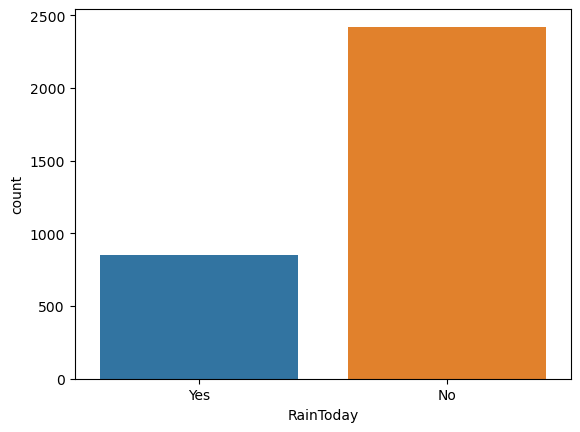

In [7]:
# Plot the distribution of the target variable
sns.countplot(x='RainToday', data=weather_data)
plt.show()

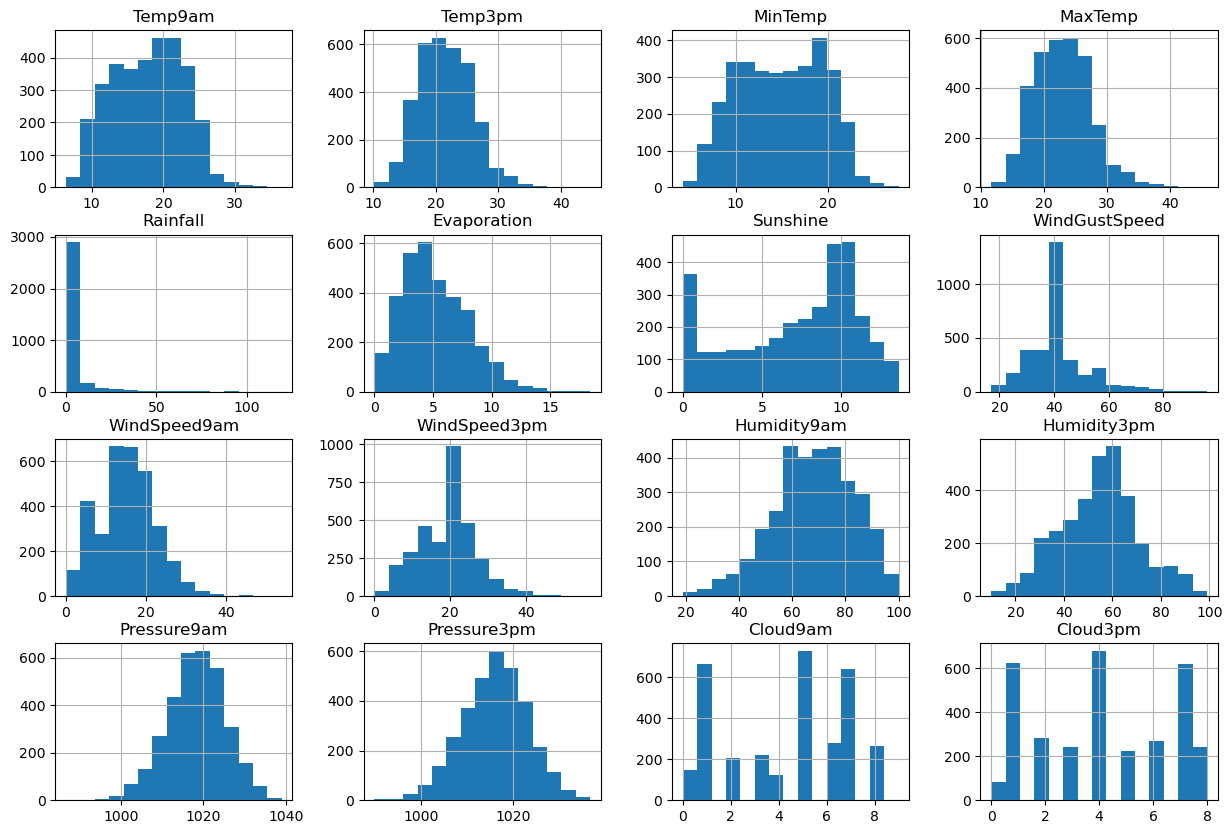

In [8]:
# Feature distribution
# Histograms for all numerical features
weather_data.hist(bins=15, figsize=(15, 10), layout=(4, 4))
plt.show()

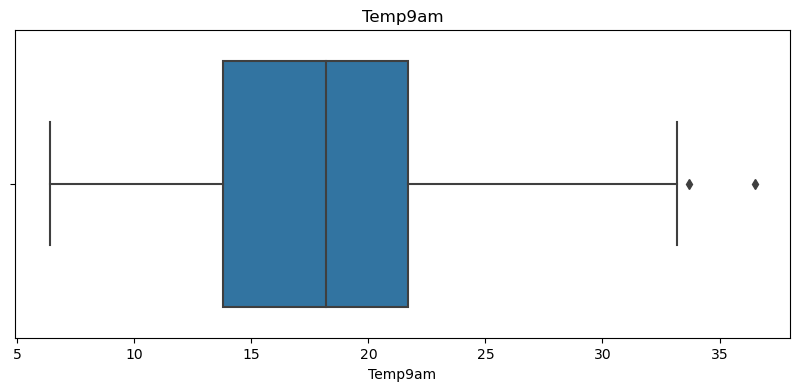

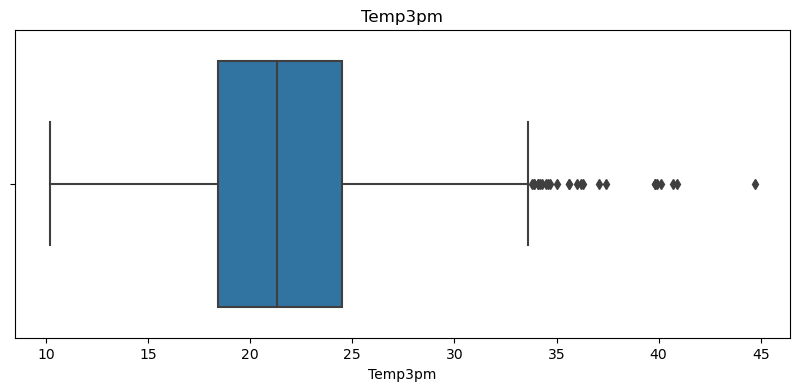

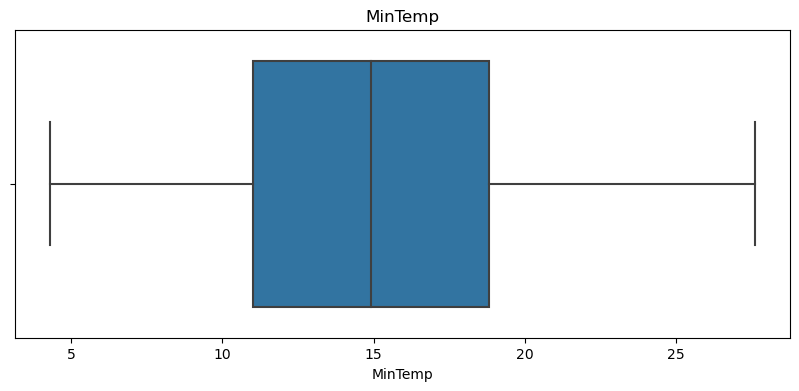

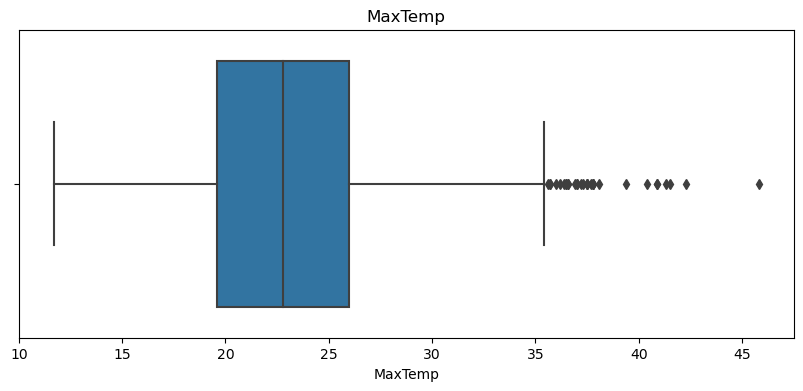

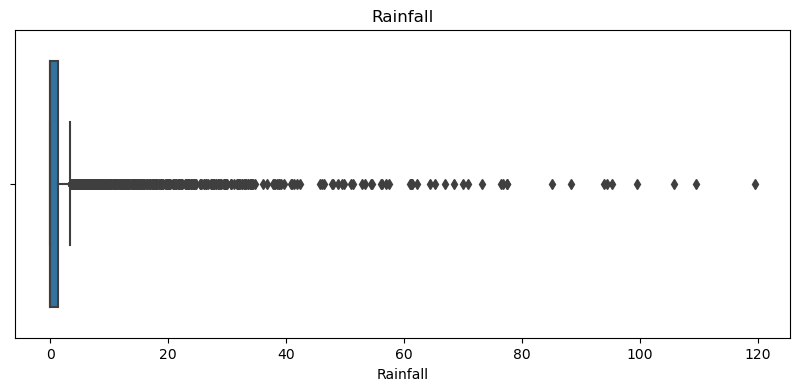

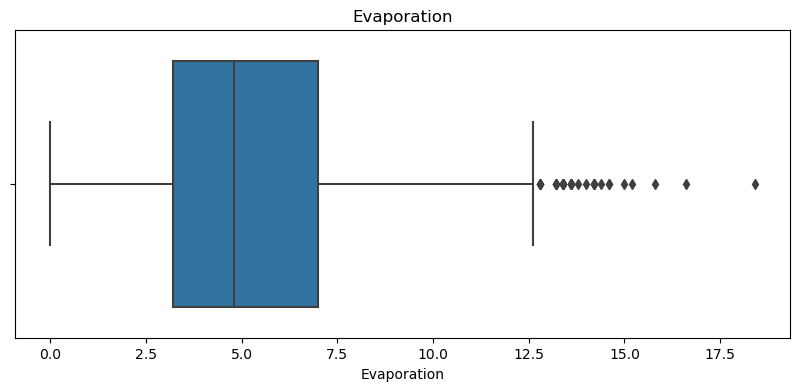

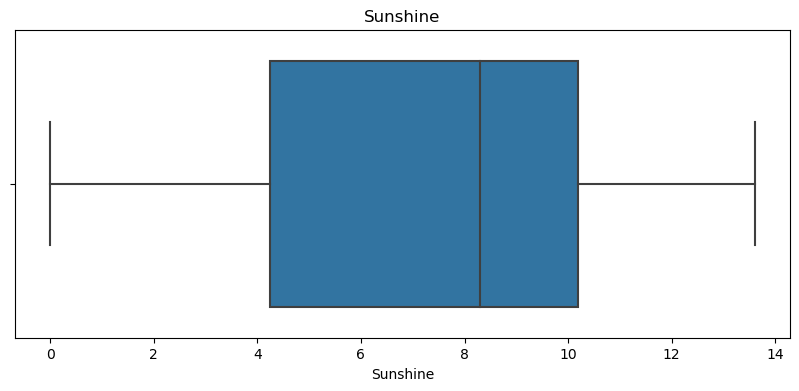

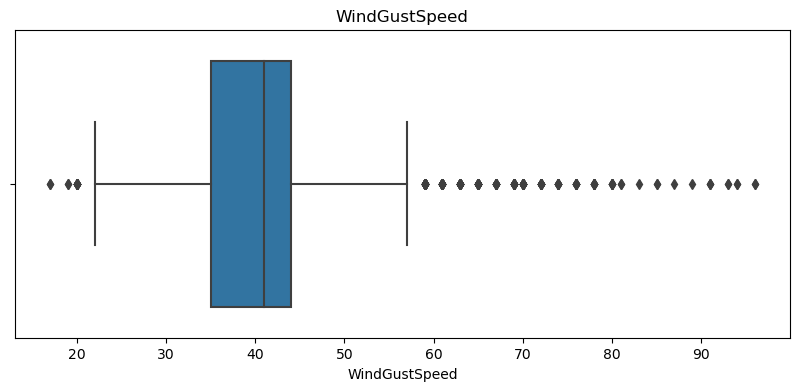

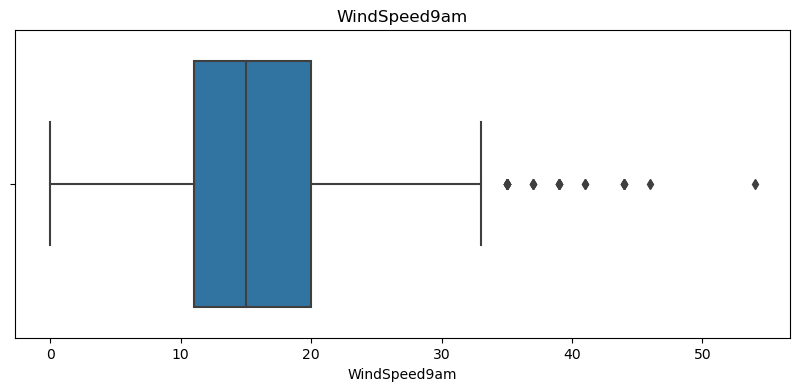

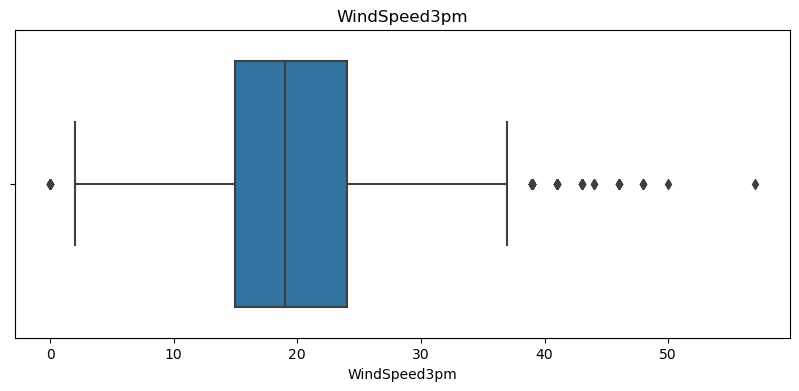

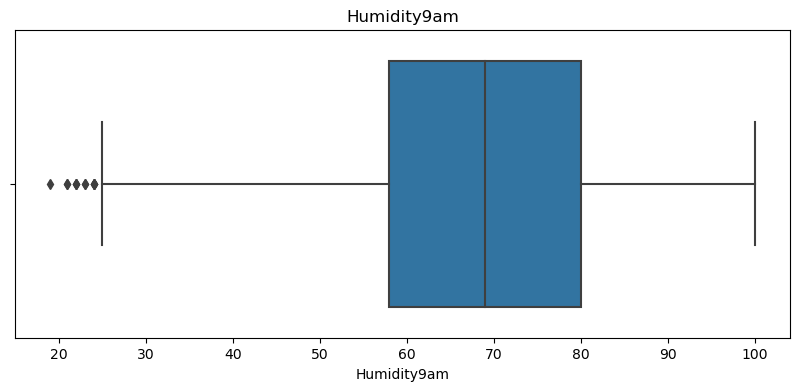

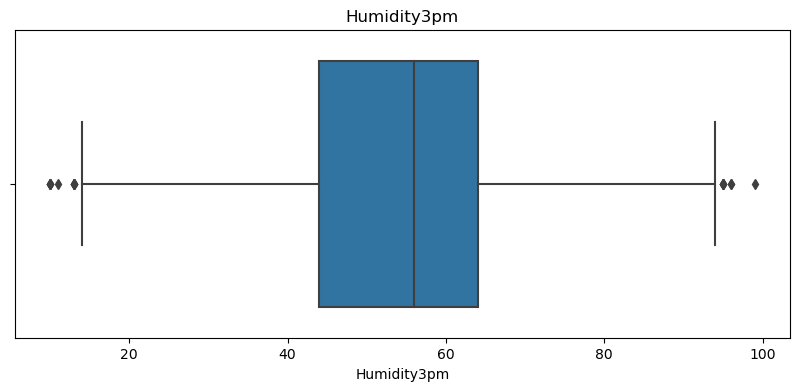

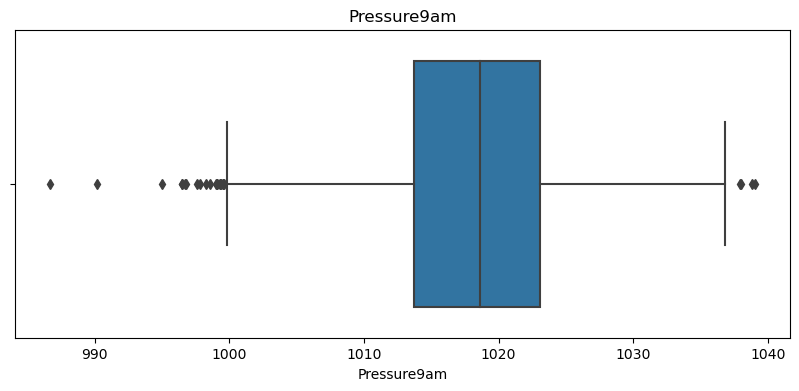

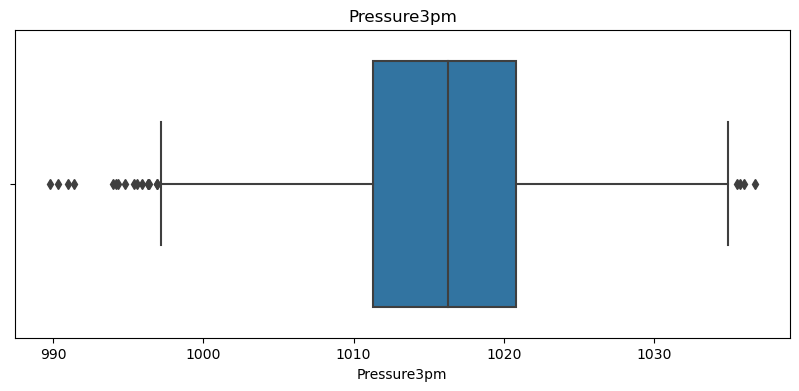

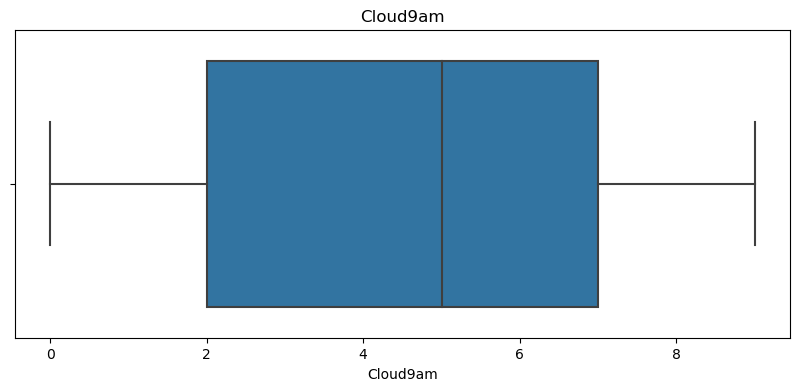

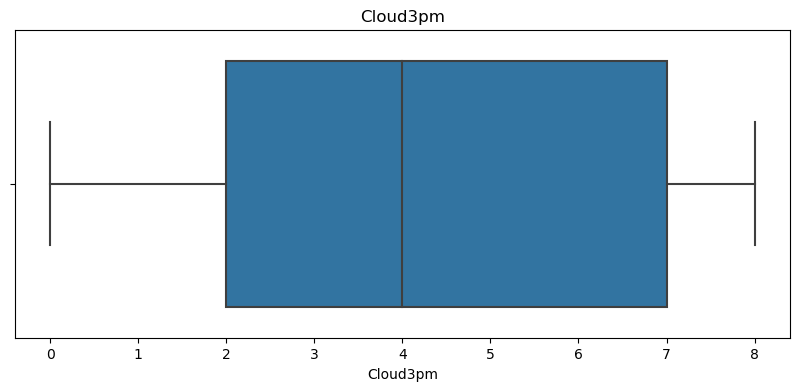

In [9]:
# Boxplots for all numerical features
numeric_columns = weather_data.select_dtypes(include=['float64', 'int64']).columns
for column in numeric_columns:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=weather_data[column])
    plt.title(column)
    plt.show()

/var/folders/kk/r29wd8kj56g0l6y20z21b1680000gn/T/ipykernel_11254/1971592857.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = weather_data.corr()


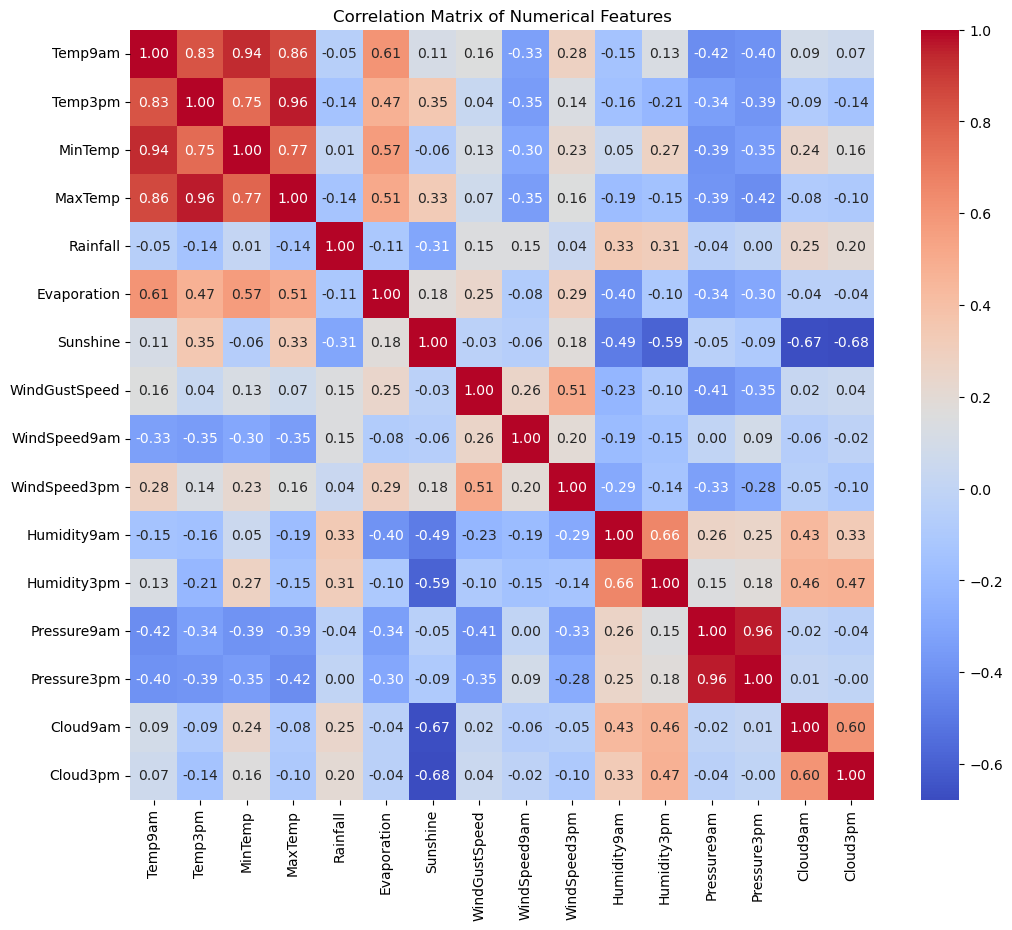

In [10]:
# Calculate the correlation matrix
correlation_matrix = weather_data.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [11]:
# Check for missing values
missing_values = weather_data.isnull().sum()
print(f"Missing values in each column:\n{missing_values}")

Missing values in each column:
Date             0
Temp9am          0
Temp3pm          0
MinTemp          0
MaxTemp          0
Rainfall         0
RainToday        0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
dtype: int64


# EDA Conclusions

- The dataset has 3271 rows and 21 columns
- There are more non-rainy days (2422) than rainy days (849) in the dataset, something that we will have to address in the preprocessing stage
- Temperature features show normal distributions, whereas rainfall, evaporation, and wind speed are right-skewed
- Rainfall and evaporation exhibit numerous outliers, indicating extreme weather events
- Humidity levels are left-skewed, suggesting higher humidity is common
- Atmospheric pressure shows a bell-shaped distribution with few outliers
- Both cloud cover features display uniform distributions with notable peaks at their extremes
- There are several highly correlated features in the correlation matrix
- There are no missing values in the dataset

-----------------------

# Data preprocessing

In [12]:
# Feature Engineering: Creating average temperature and pressure
weather_data['AvgTemp'] = (weather_data['MinTemp'] + weather_data['MaxTemp']) / 2
weather_data['AvgPressure'] = (weather_data['Pressure9am'] + weather_data['Pressure3pm']) / 2

weather_data.drop(['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'Pressure9am', 'Pressure3pm'], axis=1, inplace=True)

In [13]:
weather_data.head()

,Date,Rainfall,RainToday,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Cloud9am,Cloud3pm,AvgTemp,AvgPressure
0,01-02-13,15.6,Yes,6.2,0.0,W,41,S,SSW,17,20,92,84,8,8,20.95,1017.50
1,02-02-13,6.0,Yes,3.4,2.7,W,41,W,E,9,13,83,73,7,7,22.55,1017.15
2,03-02-13,6.6,Yes,2.4,0.1,W,41,ESE,ESE,17,2,88,86,7,8,23.05,1016.15
3,04-02-13,18.8,Yes,2.2,0.0,W,41,NNE,E,22,20,83,90,8,8,21.50,1013.00
4,05-02-13,77.4,Yes,4.8,0.0,W,41,NNE,W,11,6,88,74,8,8,22.70,1006.55


In [14]:
# Extract month from 'Date' column
weather_data['Month'] = pd.to_datetime(weather_data['Date']).dt.month

# Map the month to the corresponding season in Bangladesh
season_mapping = {1: 'Winter', 2: 'Spring', 3: 'Spring', 4: 'Summer', 5: 'Summer',
                  6: 'Monsoon', 7: 'Monsoon', 8: 'Autumn', 9: 'Autumn', 
                  10: 'Late Autumn', 11: 'Late Autumn', 12: 'Winter'}
weather_data['Season'] = weather_data['Month'].map(season_mapping)

# Since we have extracted the season, we can drop the 'Date' and 'Month' columns if they are no longer needed
weather_data.drop(['Date', 'Month'], axis=1, inplace=True)

In [15]:
weather_data.head()

,Rainfall,RainToday,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Cloud9am,Cloud3pm,AvgTemp,AvgPressure,Season
0,15.6,Yes,6.2,0.0,W,41,S,SSW,17,20,92,84,8,8,20.95,1017.50,Winter
1,6.0,Yes,3.4,2.7,W,41,W,E,9,13,83,73,7,7,22.55,1017.15,Spring
2,6.6,Yes,2.4,0.1,W,41,ESE,ESE,17,2,88,86,7,8,23.05,1016.15,Spring
3,18.8,Yes,2.2,0.0,W,41,NNE,E,22,20,83,90,8,8,21.50,1013.00,Summer
4,77.4,Yes,4.8,0.0,W,41,NNE,W,11,6,88,74,8,8,22.70,1006.55,Summer


In [16]:
# Encoding the target variable
weather_data['RainToday'] = weather_data['RainToday'].map({'Yes': 1, 'No': 0})

# Identifying categorical columns
categorical_features = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'Season']

# Applying OneHotEncoder
onehotencoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_features = onehotencoder.fit_transform(weather_data[categorical_features])

# Creating a DataFrame from the encoded features
encoded_features_df = pd.DataFrame(encoded_features, columns=onehotencoder.get_feature_names_out(categorical_features))

# Save the OneHotEncoder with pickle
with open('oh_encoder_weather_1.pkl', 'wb') as file:
    pickle.dump(onehotencoder, file)

# Concatenate the encoded features back to the original dataset and drop the original categorical columns
weather_data = pd.concat([weather_data.drop(categorical_features, axis=1), encoded_features_df], axis=1)

# Perform the train-test split
X = weather_data.drop(['RainToday','Rainfall'], axis=1)
y = weather_data['RainToday']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training set to balance it
'''smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
'''
from imblearn.under_sampling import RandomUnderSampler

# Define the under-sampling method
under_sampler = RandomUnderSampler(random_state=42)

# Apply the under-sampling method to the data
X_train_balanced, y_train_balanced = under_sampler.fit_resample(X_train, y_train)

# Initialize the RobustScaler
scaler = RobustScaler()

# Fit the scaler on the balanced training set and transform both the balanced training and test sets
X_train_balanced_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

with open('scaler_weather_1.pkl', 'wb') as file:
    pickle.dump(scaler, file)

/Users/javiertorres/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [17]:
X_train.head()

,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Cloud9am,Cloud3pm,AvgTemp,...,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,Season_Autumn,Season_Late Autumn,Season_Monsoon,Season_Spring,Season_Summer,Season_Winter
790,5.0,9.9,41,15,20,68,55,2,6,20.70,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2962,4.8,10.0,48,11,24,66,37,0,6,17.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1022,5.4,2.5,39,11,19,59,50,5,4,18.30,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1025,8.8,11.7,46,7,28,78,65,5,4,24.30,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2991,5.4,8.8,37,6,19,52,44,1,7,16.55,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [18]:
final_column_order = X_train.columns.tolist()

# Save the column order
with open('col_order_weather_1.pkl', 'wb') as file:
    pickle.dump(final_column_order, file)

----------------

# Model training

In [19]:
from sklearn.metrics import roc_auc_score

# Define the XGBClassifier model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'gamma': [0, 1, 5],  # Regularization parameter
    'reg_alpha': [0, 0.1],  # L1 regularization
    'reg_lambda': [1, 1.5],  # L2 regularization
}

# Set up the grid search with cross-validation
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=1)

# Fit the grid search to the data
grid_search_xgb.fit(X_train_balanced_scaled, y_train_balanced)

# Get the best estimator
best_xgb = grid_search_xgb.best_estimator_

# Predict the probability of the positive class on the training set
y_train_probs_xgb = best_xgb.predict_proba(X_train_balanced_scaled)[:, 1]

# Predict the probability of the positive class on the test set
y_test_probs_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC AUC scores
train_auc_xgb = roc_auc_score(y_train_balanced, y_train_probs_xgb)
test_auc_xgb = roc_auc_score(y_test, y_test_probs_xgb)

# Print the best parameters and ROC AUC scores
print(f"Best parameters found: {grid_search_xgb.best_params_}")
print(f"Training ROC AUC Score: {train_auc_xgb}")
print(f"Test ROC AUC Score: {test_auc_xgb}")

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters found: {'colsample_bytree': 0.7, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.7}
Training ROC AUC Score: 0.9499131209623524
Test ROC AUC Score: 0.836157926857894


In [21]:
# Save the model to a file
with open('models/xgb_weather_1.pkl', 'wb') as file:
    pickle.dump(best_xgb, file)